In [5]:
%matplotlib  inline
import pandas as pd
import iexfinance as iex
from datetime import datetime
import quandl
import plotly as py
import plotly.graph_objs as go
import xgboost
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.cross_validation import *
import sklearn.preprocessing as prep
import sklearn.feature_selection as fs
import sklearn.model_selection as ms
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from scipy import poly1d
from scipy.stats import pearsonr
import seaborn as sns
from math import sqrt
import datetime
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()
from pykalman import KalmanFilter
pd.set_option('display.max_columns', 100)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



In [279]:
import scipy.ndimage as ndimage

def customLoss(actual,pred):
    alpha = 100
    t = 0
    if (actual * pred > 0):
        t = abs(actual-pred)
    else:
        t = alpha*pred**2 - np.sign(actual)*pred + abs(actual)
    return (t)

def macd(close, n_fast=12, n_slow=26,  n_sign=9, fillna=True):
    emafast = close.ewm(n_fast).mean()
    emaslow = close.ewm(n_slow).mean()
    macd = emafast - emaslow
    if fillna:
        macd = macd.fillna(0)
    macdsig = macd.ewm(n_sign).mean()
    if fillna:
        macd = macd.fillna(0)
        macdsig = macdsig.fillna(0)
    return macd, macdsig

def simple_returns(df):
    df = df.pct_change().fillna(0)
    return df

def rsi(close, n=14, fillna=True):
    diff = close.diff()
    which_dn = diff < 0

    up, dn = diff, diff*0
    up[which_dn], dn[which_dn] = 0, -up[which_dn]

    emaup = up.ewm(n).mean()
    emadn = dn.ewm(n).mean()

    rsi = 100 * emaup/(emaup + emadn)
    if fillna:
        rsi = rsi.fillna(50)
    return pd.Series(rsi, name='rsi')

def log_returns(df):
    """Calculate logReturns of price series"""
    log_ret = np.log(df) - np.log(df.shift(1))
    return log_ret

def tsi(close, r=25, s=13, fillna=True):
    """Calculate TSI Indicator of close price series"""
    m = close - close.shift(1)
    m1 = m.ewm(r).mean().ewm(s).mean()
    m2 = abs(m).ewm(r).mean().ewm(s).mean()
    tsi = m1/m2
    if fillna:
        tsi = tsi.fillna(0)
    return pd.Series(100*tsi, name='tsi')

def on_balance_volume(close, volume):
    """Calculate OBV Indicator of close price series and Volume"""
    df = pd.DataFrame([close, volume]).transpose()
    df['OBV'] = 0
    c1 = close < close.shift(1)
    c2 = close > close.shift(1)
    if c1.any():
        df.loc[c1, 'OBV'] = - volume
    if c2.any():
        df.loc[c2, 'OBV'] = volume
    return df['OBV']

def average_true_range(high, low, close, n=14, fillna=False):
    """Average True Range (ATR)
    The indicator provide an indication of the degree of price volatility.
    Strong moves, in either direction, are often accompanied by large ranges,
    or large True Ranges.
    http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:average_true_range_atr
    Args:
        high(pandas.Series): dataset 'High' column.
        low(pandas.Series): dataset 'Low' column.
        close(pandas.Series): dataset 'Close' column.
        n(int): n period.
    Returns:
        pandas.Series: New feature generated.
    """
    cs = close.shift(1)
    tr = high.combine(cs, max) - low.combine(cs, min)
    tr = tr.ewm(n).mean()
    if fillna:
        tr = tr.fillna(0)
    return pd.Series(tr, name='atr')

def kst(close, r1=10, r2=15, r3=20, r4=30, n1=10, n2=10, n3=10, n4=15, nsig=9, fillna=True):
    """Calculate KST Indicator of close price series. See https://en.wikipedia.org/wiki/KST_oscillator"""
    rocma1 = (close / close.shift(r1) - 1).rolling(n1).mean()
    rocma2 = (close / close.shift(r2) - 1).rolling(n2).mean()
    rocma3 = (close / close.shift(r3) - 1).rolling(n3).mean()
    rocma4 = (close / close.shift(r4) - 1).rolling(n4).mean()
    kst = 100*(rocma1 + 2*rocma2 + 3*rocma3 + 4*rocma4)
    sig = kst.rolling(nsig).mean()
    if fillna:
        sig = sig.fillna(0)
    return pd.Series(sig, name='sig')

def find_nearest(array, value,findMax=True):
    """Find nearest value of extreme value"""
    array = np.sort(np.asarray(array))
    if findMax:
        array = array[array>=value]
    else:
        array = array[array<=value]
    if array.size > 0:
        idx = (np.abs(array - value)).argmin()
        return array[idx]
    else:
        return np.nan

def local_extreme(array, min_distance = 20, periodic=False, edges_allowed=True,find_max=True): 
    """Find all local maxima of the array, separated by at least min_distance."""
    array = np.asarray(array)
    cval = 0 
    if periodic: 
        mode = 'wrap' 
    elif edges_allowed: 
        mode = 'nearest' 
    else: 
        mode = 'constant' 
    cval = array.max()+1 
    if find_max:
        max_points = array == ndimage.maximum_filter(array, 1+2*min_distance, mode=mode, cval=cval) 
    else:
        max_points = array == ndimage.minimum_filter(array, 1+2*min_distance, mode=mode, cval=cval) 
        
    return [indices[max_points] for indices in np.indices(array.shape)]

def extreme_significance(exArray, tolerance=0.02,signi_level=2):
    """Find Significance of extreme values within tolerance bound."""
    array = np.asarray(exArray)
    array = np.ravel(array)
    signifArr = np.zeros(len(array))
    d = {'data': array, 'sign': signifArr}
    result = pd.DataFrame(data=d).values
    #print('len of x is: '+repr(len(result)))
    for i in range(len(result)):
        val = result[i,0]
        signif = 0
        for j in range(i+1,len(result)):
            if (result[j,0]>= val*(1-tolerance)) and  (array[j]<= val*(1+tolerance)):
                    signif = signif + 1
            result[i,1] = signif
            
    result = pd.DataFrame(data=result,columns=['ExtremeValue', 'Significance'])
    result = result[result.Significance>=signi_level]
    return result.sort_values(by=['Significance'],ascending=False)

def grouper(iterable, tolerance):
    """Group extremes by cluster based on relative price distance."""
    # if Dataframe take first column
    if isinstance(iterable,pd.core.frame.DataFrame):
        iterable = iterable.sort_values(by=iterable.columns[0]).iloc[:,0].values
    elif isinstance(iterable,np.ndarray):
        iterable =np.sort(iterable)
    prev = None
    group = []
    for item in iterable:
        if not prev or item - prev <= tolerance*item:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group
def group_extremes(inp,max_distance):
    """Calculate centroid for each cluster of prices"""
    inp = dict(enumerate(grouper(inp,max_distance), 1))
    avgDict = {}
    for k,v in inp.items():
        # v is the list of items for dict row k
        avgDict[k] = sum(v)/ float(len(v))
    return list(avgDict.values())

def highest_high(df,window=21):
    df = df.rolling(window=window,center=False,min_periods=1).max()
    return df

def momentum(df,period=10):
    df = df - df.shift(period)
    df[0:period] = 0
    return df

def trading_range(df_high,df_low):
    df = df_high-df_low
    return df

def lowest_low(df,window=21):
    df = df.rolling(window=window,center=False,min_periods=1).min()
    return df

def calc_extreme_distance(series,sup_array,res_array):
    import math
    if isinstance(series,pd.core.frame.DataFrame):
        series = np.ravel(series.values())
    elif isinstance(series,np.ndarray):
        series =np.ravel(series)
    sup_array = np.ravel(np.array(sup_array))
    res_array = np.ravel(np.array(res_array))
    dist_s = []
    dist_r = []
    #if not sup_array:
    #    print("test")
    #else:
    for i in range(len(series)):
        curr_value = series[i]
        nearest_sup = find_nearest(sup_array, curr_value,findMax=False)
        nearest_res = find_nearest(res_array, curr_value)
        if curr_value*1.1 < nearest_sup:
            dist_s.append(curr_value/2)
        elif curr_value > nearest_res*1.1:
            dist_r.append(curr_value/2)
        else:
            sup_val = curr_value-nearest_sup
            res_val = nearest_res-curr_value
            if np.isnan(sup_val):
                sup_val = (curr_value/2)
            if np.isnan(res_val):
                res_val = (curr_value/2)
            dist_s.append(sup_val)
            dist_r.append(res_val)
    if dist_s and dist_r:
        return dist_s,dist_r
    
def r_score(y_true, y_pred, sample_weight=None, multioutput=None):
    r2 = r2_score(y_true, y_pred, sample_weight=sample_weight, multioutput=multioutput)
    r = (np.sign(r2)*np.sqrt(np.abs(r2)))
    if r <= -1:
        return -1
    else:
        return r
    
def calc_r_score (actual_and_test):
    r = []
    r.append(0)
    for i in range(1,len(actual_and_test)):
        ri = r_score(actual_and_test[0:i,0],actual_and_test[0:i,1])
        if ri <= -1:
            ri = 0
        r.append(ri)
    return r

def calc_kalman(dataframe):
    if isinstance(dataframe,pd.core.frame.DataFrame) or isinstance(dataframe,pd.core.series.Series):
        array = dataframe.values
    else:
        array = dataframe
    kf = KalmanFilter(transition_matrices = [1],
                      observation_matrices = [1],
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)
    state_means, _ = kf.filter(array)
    state_means = state_means.flatten()
    state_means = pd.DataFrame(data=state_means,index=dataframe.index)
    state_means.columns = ['KF']
    state_means["KF"][0:9]  = float(np.mean(state_means[9:15]).values)
    return state_means

def calc_extreme_groups (dataframe,find_max=True,mDistance = 100,tolerance=0.0009,signi_level=1):
    """Group extremes by cluster based on absolute price distance.
       Input: series or dataframe
       find_max: maximum (resistance) or minimum (suppport) search
       mDistance: minimumdistance in an array to find local extremes
       tolerance: tolerance level in percent to group other extremes
       signi_level: leave 1 """
    if isinstance(dataframe,pd.core.frame.DataFrame) or isinstance(dataframe,pd.core.series.Series):
        array = np.ravel(dataframe.values)     
    array = np.ravel(array[local_extreme(array,min_distance= mDistance,find_max=find_max)])
    signify =extreme_significance(array, tolerance=tolerance,signi_level=signi_level)
    extreme = group_extremes(signify,tolerance)
    return array,signify,extreme

def calc_next_extreme_distance (dataframe,extremes_sup=None,extremes_res=None):
    """Given a series and their supports and resistances
    calculate the distances to the next supports or resistances."""
    if isinstance(dataframe,pd.core.frame.DataFrame) or isinstance(dataframe,pd.core.series.Series):
        array = np.ravel(dataframe.values) 
    [sup,res] = calc_extreme_distance(array,extremes_sup,extremes_res) 
    sr = pd.DataFrame(data=np.transpose([sup,res]),index=dataframe.index )
    sr.columns = ['support_distance', 'resistance_distance']
    return sr

In [7]:
EURUSD = pd.read_csv('EURUSD.txt',delimiter=',',dtype={'<TIME>': str})
EURUSD.columns = EURUSD.columns.str.replace("<", "")
EURUSD.columns = EURUSD.columns.str.replace(">", "")
EURUSD = EURUSD.drop(['VOL'], axis=1)
EURUSD['DATETIME'] = EURUSD['DTYYYYMMDD'].astype(str) + ":" + EURUSD['TIME'].astype(str)
EURUSD = EURUSD.drop(['DTYYYYMMDD','TIME'], axis=1)
EURUSD['DATETIME']  = pd.to_datetime(EURUSD['DATETIME'],format='%Y%m%d:%H%M%S',  infer_datetime_format=False)
EURUSD.index = pd.to_datetime(EURUSD['DATETIME'],format='%Y%m%d:%H%M%S',  infer_datetime_format=False, unit="m")

In [278]:
EURUSD_1H = EURUSD.resample('1H').agg({'OPEN': 'first', 
                                 'HIGH': 'max', 
                                 'LOW': 'min', 
                                 'CLOSE': 'last'})

EURUSD_4H = EURUSD.resample('4H').agg({'OPEN': 'first', 
                                 'HIGH': 'max', 
                                 'LOW': 'min', 
                                 'CLOSE': 'last'})

EURUSD_1H = EURUSD_1H.dropna()
EURUSD_4H = EURUSD_4H.dropna()

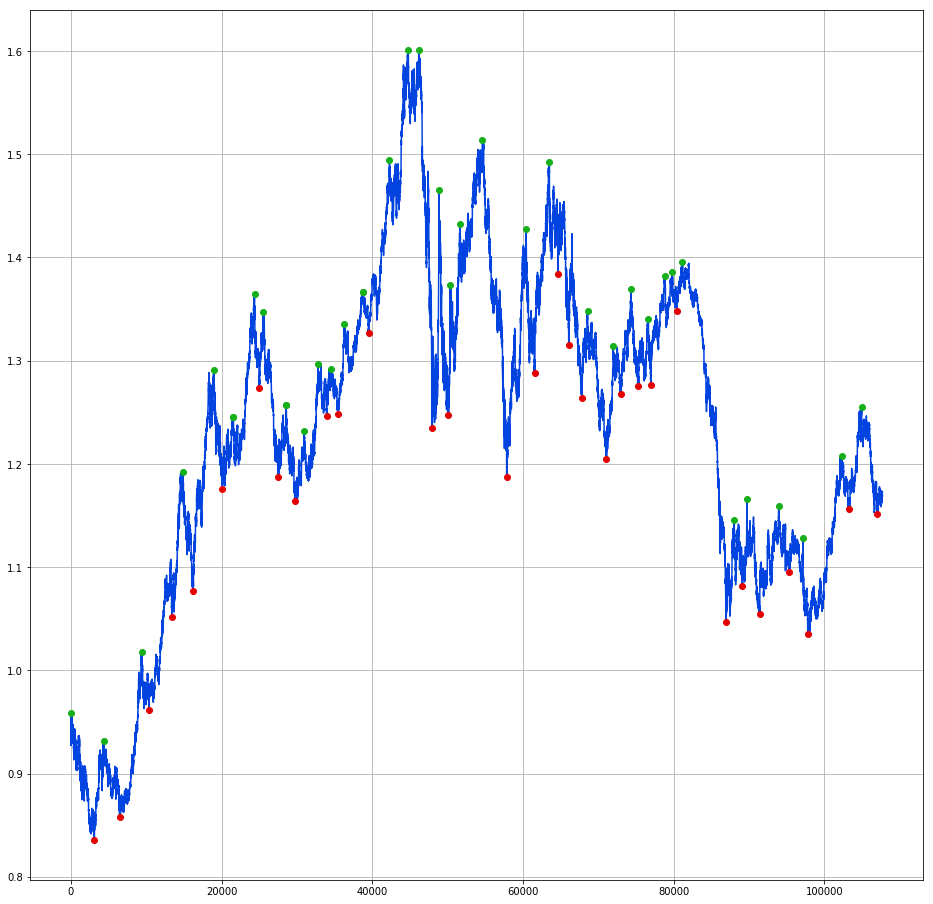

In [162]:
cl=np.ravel(EURUSD_1H[['CLOSE']].values)
plt.rc("figure",figsize=(16,16))
plt.plot(cl,color='xkcd:blue',linestyle ='-')
mDistance = 1000
plt.plot(np.ravel(local_extreme(cl,min_distance= mDistance,find_max=True)),
         np.ravel(cl[local_extreme(cl,min_distance= mDistance,find_max=True)]) ,color='xkcd:green',marker='o',linestyle ='')
plt.plot(np.ravel(local_extreme(cl,min_distance= mDistance,find_max=False)),
         np.ravel(cl[local_extreme(cl,min_distance= mDistance,find_max=False)]) ,color='xkcd:red',marker='o',linestyle ='')
plt.grid(True)

In [53]:
# # Plots
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# py.tools.set_credentials_file(username='profiler84', api_key='Jt8y8BVFAZRt6jSX6ehC')
# py.tools.set_config_file(world_readable=True, sharing='public')
# init_notebook_mode(connected=True)
# data = [go.Candlestick(x=EURUSD_1H.index, open=EURUSD_1H['OPEN'],high=EURUSD_1H['HIGH'],low=EURUSD_1H['LOW'],
#                       close=EURUSD_1H['CLOSE'])]
# py.plotly.iplot(data,filename='basic_candle', auto_open=True)


localextremes:192
signify:9  signimax:4.0
extremes:5


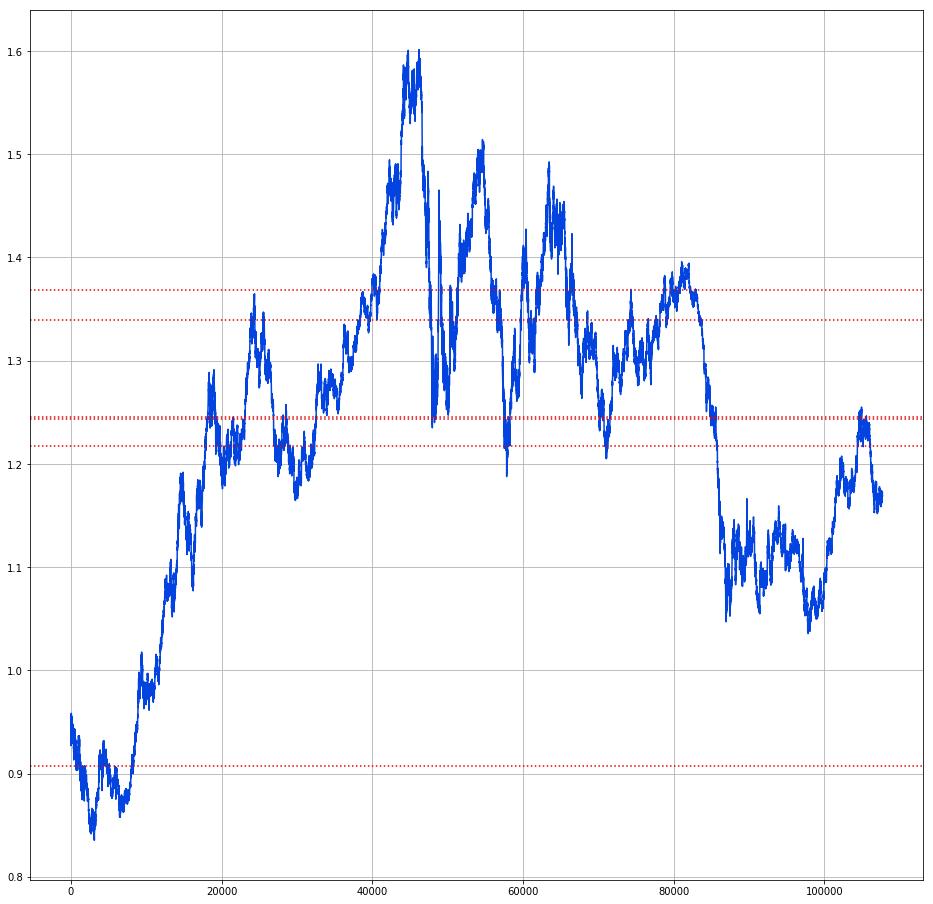

In [163]:
tolerance= 0.001
signi_level=3
min_distance= 180
array = np.ravel(cl[local_extreme(cl,min_distance= min_distance,find_max=False)])
#signify =extreme_significance(array, tolerance=tolerance,signi_level=signi_level)
signify =extreme_significance(array, tolerance=tolerance,signi_level=signi_level)
extreme = group_extremes(signify,tolerance)
print('localextremes:' + repr(len(array)))
print('signify:' + repr(len(signify)), ' signimax:' +repr(np.max(signify['Significance'])))
print('extremes:' + repr(len(extreme)))
      
arr,sign,extremes_res = calc_extreme_groups(EURUSD_1H[['CLOSE']],signi_level=signi_level,
                                   tolerance=tolerance,mDistance = min_distance,find_max=True)
plt.rc("figure",figsize=(16,16))
plt.plot(cl,color='xkcd:blue',linestyle ='-')
yval = np.ravel(extremes_res)
for x in yval:
    plt.axhline(y=x,color='xkcd:red',linestyle =':')
plt.grid(True)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning:

invalid value encountered in reduce



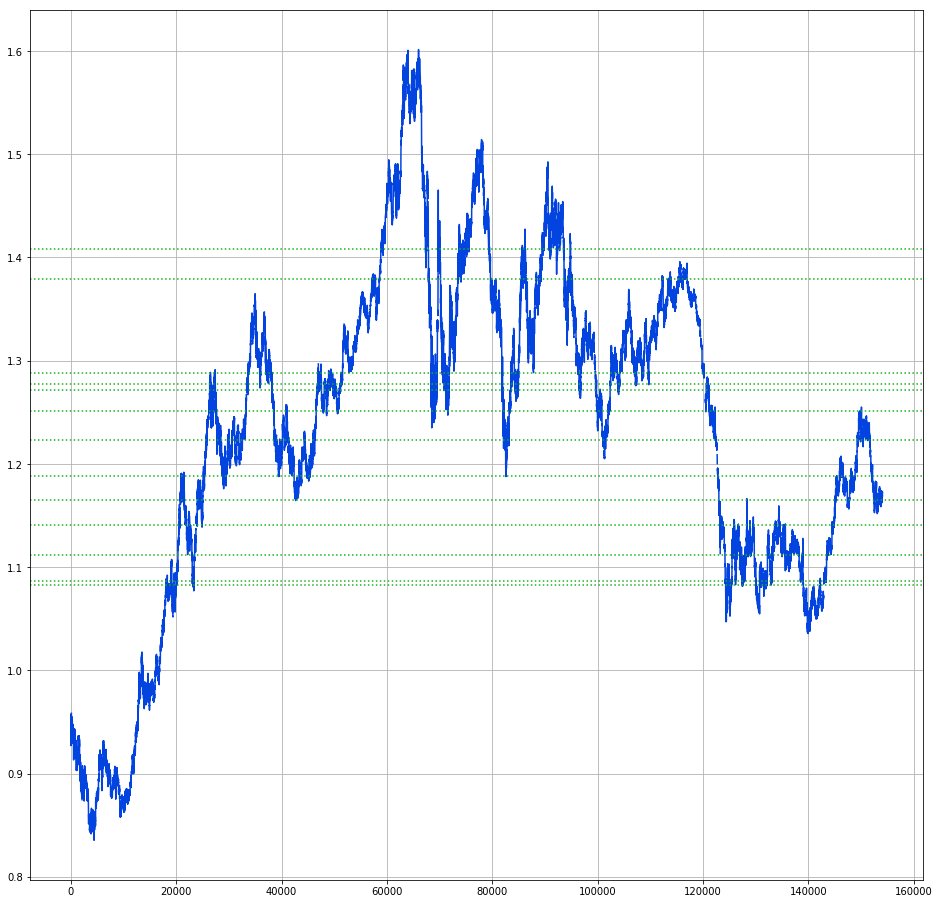

In [119]:
# Show horizontal resistance levels based on extreme points and significance
__,__,extremes_sup = calc_extreme_groups(EURUSD_1H[['CLOSE']],signi_level=signi_level,
                                   tolerance=tolerance,mDistance = min_distance,find_max=False)
plt.rc("figure",figsize=(16,16))
plt.plot(cl,color='xkcd:blue',linestyle ='-')
yval = np.ravel(extremes_sup)
for x in yval:
    plt.axhline(y=x,color='xkcd:green',linestyle =':')
plt.grid(True)

In [266]:
def feature_engineering_dates(df):
    import pandas as pd
    from datetime import timedelta
    #df['Date'] = pd.to_datetime("'2015-10-01'") # I guess this date is right :P
    #df['Date'] = df['DATETIME'] + df['Day'].map(timedelta) - timedelta(days=1)
    df['Year'] = df.index.year
    df['Month'] = df.index.month
    df['Week'] = df.index.weekofyear
    df['Weekday'] = df.index.weekday
    df['DayMonth'] = df.index.day
    return df

def feature_engineering_ta(df):
        # bollinger bands
    df['TSI'] = tsi(df['CLOSE'])
    df['ATR'] = average_true_range(df['HIGH'],df['LOW'],df['CLOSE'])
    df['KF'] = calc_kalman(df['CLOSE'])
    df['KST'] = kst(df['CLOSE'])
    df['HIGHESTHIGH'] = highest_high(df['HIGH'])
    df['LOWESTLOW'] = lowest_low(df['LOW'])
    df['TRADINGRANGE'] = trading_range(df['HIGH'],df['LOW'])
    df['MOMENTUM'] = momentum(df['CLOSE'])
    df['RSI'] = rsi(df['CLOSE'])
    df['MACD'],df['MACDSIGNAL'] = macd(df['CLOSE'])
    return df

def feature_engineering_statistics(df_grouped,cols):
    for c in cols:
        # rolling
        for h in [11, 21]:
            df_grouped[c+'_rolling_mean_'+str(h)] = df_grouped[c].rolling(h, min_periods=0).mean()
        # diffs
        df_grouped[c+'_diff_1'] = df_grouped[c].diff().fillna(method="backfill")
        df_grouped[c+'_diff_2'] = df_grouped[c].diff(2).fillna(method="backfill")
        df_grouped[c+'_diff_3'] = df_grouped[c].diff(3).fillna(method="backfill")
        # cumsum
        df_grouped[c+'_cumsum'] = df_grouped[c].cumsum()
        # shift columns
        df_grouped[c+'_shift1'] = df_grouped[c].shift(1).fillna(0)
        df_grouped[c+'_shift2'] = df_grouped[c].shift(2).fillna(0)
        df_grouped[c+'_shift3'] = df_grouped[c].shift(3).fillna(0)
    return df_grouped


In [267]:
EURUSD_1H = feature_engineering_ta(EURUSD_1H)

In [275]:
cols = ['TSI','ATR','KF','KST','HIGHESTHIGH','LOWESTLOW','TRADINGRANGE','MOMENTUM','RSI','MACD','MACDSIGNAL']
EURUSD_1H = feature_engineering_statistics(EURUSD_1H,cols)

In [ ]:
sig = 0
profit = 0.001
target = np.zeros((len(EURUSD_1H),3))
start = time.time()
for i in range(len(EURUSD_1H)):
    start = EURUSD_1H['CLOSE'][i]
    for j in range(i+1,len(EURUSD_1H)):
        if (EURUSD_1H['CLOSE'][j]*(1+profit) >= start):
            end = EURUSD_1H['CLOSE'][j]
            distance = j-i
            profit = 1
            target[i,0] = profit
            target[i,1] = distance
            target[i,2] = end
            break
        elif (EURUSD_1H['CLOSE'][j]*(1-profit) <= start):
            end = EURUSD_1H['CLOSE'][j]
            distance = j-i
            profit = -1
            target[i,0] = profit
            target[i,1] = distance
            target[i,2] = end
            break
EURUSD_1H['TARGET'] = target[:,0]
EURUSD_1H['DISTANCE'] = target[:,1]
EURUSD_1H['PRICEHIT'] = target[:,2]
end = time.time()
print('time elapsed: ' + str(end - start))

In [298]:
EURUSD_1H.head(22)

,OPEN,HIGH,LOW,CLOSE,TARGET,DISTANCE,PRICEHIT
DATETIME,,,,,,,
2001-01-02 23:00:00,0.9507,0.9509,0.9505,0.9506,-1.0,1.0,0.9496
2001-01-03 00:00:00,0.9506,0.9510,0.9492,0.9496,-1.0,1.0,0.9505
2001-01-03 01:00:00,0.9496,0.9509,0.9495,0.9505,-1.0,1.0,0.9499
2001-01-03 02:00:00,0.9504,0.9508,0.9498,0.9499,-1.0,1.0,0.9503
2001-01-03 03:00:00,0.9499,0.9507,0.9499,0.9503,-1.0,1.0,0.9506
2001-01-03 04:00:00,0.9503,0.9506,0.9503,0.9506,-1.0,1.0,0.9505
2001-01-03 05:00:00,0.9506,0.9507,0.9505,0.9505,-1.0,1.0,0.9509
2001-01-03 06:00:00,0.9505,0.9513,0.9503,0.9509,-1.0,1.0,0.9489
2001-01-03 07:00:00,0.9510,0.9510,0.9468,0.9489,-1.0,1.0,0.9539
